# 6. Kết luận - Đánh giá tính khả thi của dữ liệu

Trong notebook này, chúng ta sẽ đánh giá tính khả thi của bài toán phân loại bài viết VNExpress thành hai nhóm: **Khoa học** và **Công nghệ** dựa trên kết quả phân tích từ các notebook trước. Đồng thời, chúng ta sẽ xác định tập đặc trưng hữu ích cho việc xây dựng mô hình phân loại.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Thiết lập để hiển thị biểu đồ đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Để hiển thị Tiếng Việt đúng
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Đọc dữ liệu đã xây dựng đặc trưng từ notebook 4
df_features = pd.read_csv('../clean_data/vnexpress_featured_data.csv', encoding='utf-8-sig')

# Lấy thông tin cơ bản về dữ liệu
print(f"Kích thước dữ liệu: {df_features.shape}")
print(f"Phân bố nhóm bài viết:\n{df_features['group'].value_counts()}")
print(f"Tỷ lệ dữ liệu: Công nghệ {df_features['group'].value_counts()['Công nghệ']/len(df_features)*100:.2f}%, "
      f"Khoa học {df_features['group'].value_counts()['Khoa học']/len(df_features)*100:.2f}%")

Kích thước dữ liệu: (1182, 80)
Phân bố nhóm bài viết:
group
Công nghệ    604
Khoa học     578
Name: count, dtype: int64
Tỷ lệ dữ liệu: Công nghệ 51.10%, Khoa học 48.90%


## 6.1. Tổng hợp kết quả phân tích từ các notebook trước

### 6.1.1. Từ notebook 1: Tổng quan dữ liệu

- **Dữ liệu ban đầu**: Khoảng 1.200 bài viết từ VNExpress thuộc 2 nhóm: Công nghệ và Khoa học.
- **Cấu trúc dữ liệu**: Bao gồm các trường như tiêu đề, mô tả, nội dung, nhóm, thể loại, ngày xuất bản, tác giả, URL, ảnh đại diện, tags, số lượng bình luận.
- **Phân bố dữ liệu**: Khá cân bằng giữa 2 nhóm (khoảng 51% Công nghệ và 49% Khoa học), là điều kiện lý tưởng cho bài toán phân loại.

### 6.1.2. Từ notebook 2: Làm sạch dữ liệu

- **Xử lý dữ liệu thiếu**: Đã điền giá trị cho các trường văn bản bị thiếu, thay thế các giá trị null trong category, thumbnail, author.
- **Làm sạch văn bản**: Loại bỏ HTML tags, URL, ký tự đặc biệt và chuẩn hóa khoảng trắng từ nội dung, tiêu đề, mô tả.
- **Chuẩn hóa thời gian**: Chuyển đổi thành chuẩn datetime và trích xuất các thông tin như năm, tháng, ngày, giờ, ngày trong tuần.
- **Phân tích phân bố**: Các bài viết được phân bố khá đồng đều theo thời gian (giờ, ngày, tháng).

### 6.1.3. Từ notebook 3: Mã hóa dữ liệu

- **Vector hóa văn bản**: Sử dụng TF-IDF với 5000 đặc trưng cho nội dung văn bản, sau khi loại bỏ stopwords tiếng Việt và tiếng Anh.
- **Phân tích từ khóa**: Xác định những từ khóa khác biệt giữa 2 nhóm bài viết:
  - **Công nghệ**: ai, điện thoại, apple, công nghệ, dữ liệu, smartphone, internet, mạng, ứng dụng, pin...
  - **Khoa học**: nghiên cứu, phát hiện, trái đất, khoa học, bệnh, não, loài, gen, vaccine, không gian...
- **Mã hóa biến danh mục**: One-hot encoding cho category và các tags phổ biến.

### 6.1.4. Từ notebook 4: Xây dựng đặc trưng

- **Đặc trưng mới**: Đã tạo các đặc trưng như tỷ lệ tiêu đề/nội dung, phân loại thời gian đăng bài, độ phức tạp văn bản.
- **Phân tích tầm quan trọng**: Sử dụng Chi2 và ANOVA F-value để xác định các đặc trưng quan trọng trong việc phân loại.
- **Giảm chiều**: Áp dụng PCA để giảm số chiều dữ liệu xuống còn khoảng 10-15 thành phần chính, giữ lại 95% phương sai.
- **Tập đặc trưng tinh gọn**: Kết hợp đặc trưng TF-IDF quan trọng, đặc trưng kỹ thuật và thành phần PCA.

### 6.1.5. Từ notebook 5: Phân tích đa biến

- **Tương quan đặc trưng**: Phát hiện nhiều đặc trưng có tương quan mạnh với việc phân loại nhóm.
- **Khả năng phân tách**: Kết quả t-SNE và silhouette score cho thấy có sự phân tách khá rõ ràng giữa 2 nhóm bài viết.
- **Phân phối đặc trưng**: Các đặc trưng TF-IDF và kỹ thuật có phân phối khác nhau giữa 2 nhóm, hỗ trợ việc phân loại.

## 6.2. Đánh giá tính khả thi của bài toán

Bây giờ chúng ta sẽ đánh giá tính khả thi của bài toán phân loại bài viết VNExpress thành hai nhóm: Công nghệ và Khoa học dựa trên các tiêu chí sau:

### 6.2.1. Cân bằng dữ liệu

Đầu tiên, chúng ta kiểm tra lại tính cân bằng của dữ liệu:

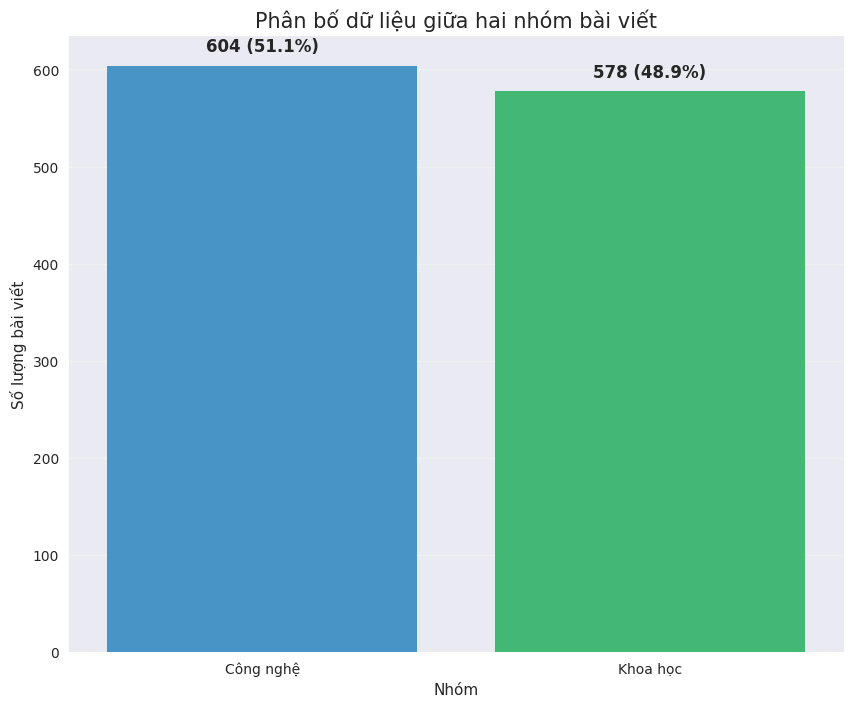

In [3]:
# Trực quan hóa sự cân bằng của dữ liệu
plt.figure(figsize=(10, 8))
sns.countplot(x='group', data=df_features, palette=['#3498db', '#2ecc71'])
plt.title('Phân bố dữ liệu giữa hai nhóm bài viết', fontsize=15)
plt.xlabel('Nhóm')
plt.ylabel('Số lượng bài viết')

# Thêm nhãn số lượng trên mỗi cột
for i, count in enumerate(df_features['group'].value_counts()):
    plt.text(i, count + 10, f"{count} ({count/len(df_features)*100:.1f}%)", 
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

**Nhận xét**: Dữ liệu khá cân bằng giữa hai nhóm Công nghệ và Khoa học, một điều kiện lý tưởng cho bài toán phân loại. Ta không cần áp dụng các kỹ thuật cân bằng dữ liệu phức tạp như oversampling hay undersampling.

### 6.2.2. Khả năng phân biệt của đặc trưng

Để đánh giá khả năng phân biệt của các đặc trưng, ta xem lại kết quả t-SNE từ notebook 5:

  File "d:\GiaoPhan_Workspace\sem_6\khoa_hoc_du_lieu\vnexpress-analysis-project\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


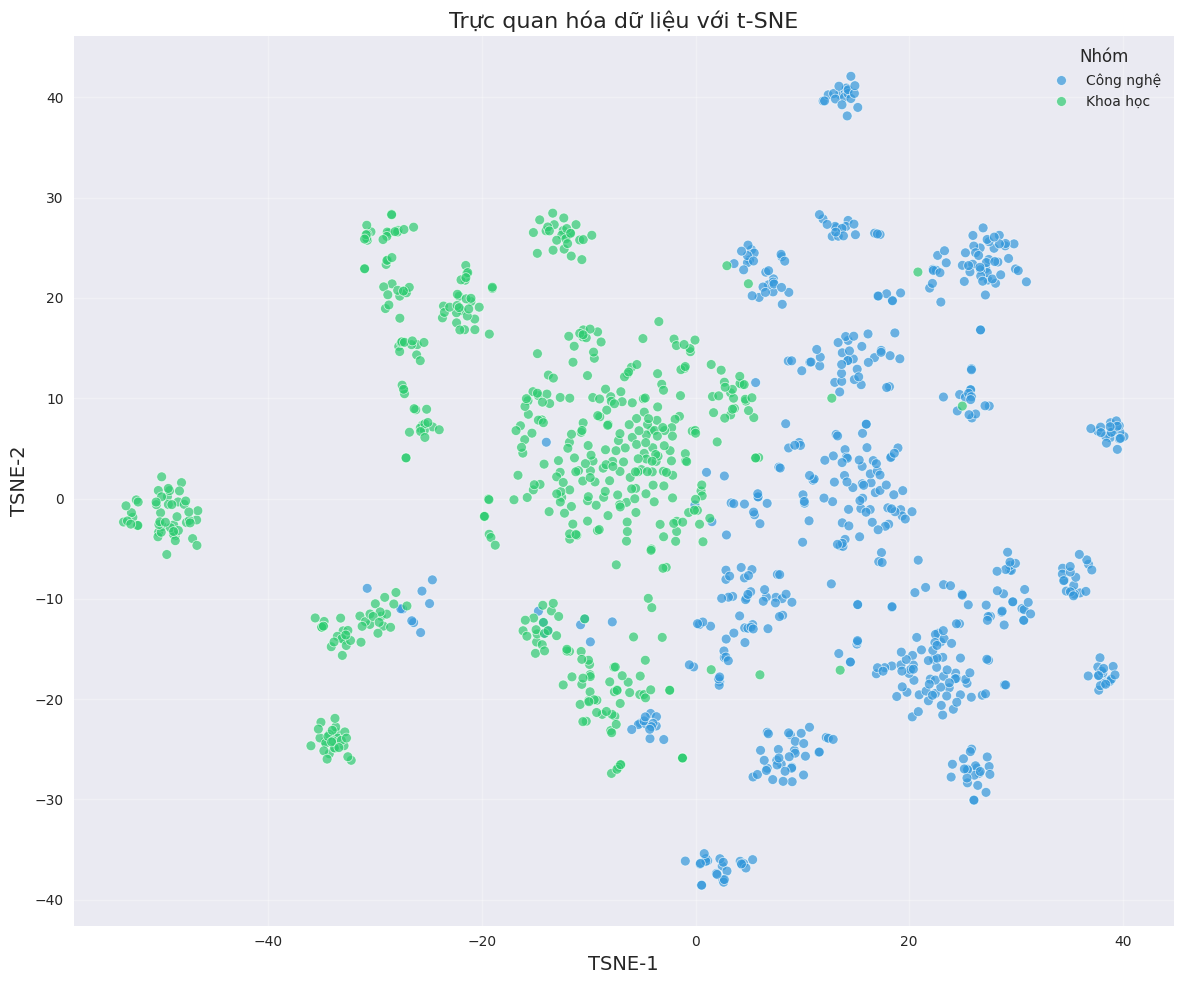

In [6]:
from sklearn.manifold import TSNE

# Chuẩn bị dữ liệu cho t-SNE
# Chọn các cột số làm đặc trưng, loại bỏ cột 'group'
feature_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
X = df_features[feature_cols].values

# Kiểm tra và xử lý NaN và inf
X = np.nan_to_num(X, nan=0)  # Thay thế NaN bằng 0
X = np.where(np.isinf(X), 0, X)  # Thay thế các giá trị vô hạn bằng 0

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_scaled = np.nan_to_num(X_scaled, nan=0)  # Đảm bảo không có NaN sau khi chuẩn hóa
X_scaled = np.where(np.isinf(X_scaled), 0, X_scaled)  # Đảm bảo không có inf sau khi chuẩn hóa
tsne_result = tsne.fit_transform(X_scaled)

# Tạo DataFrame từ kết quả t-SNE
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE-1', 'TSNE-2'])
tsne_df['group'] = df_features['group']

# Trực quan hóa kết quả t-SNE
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='TSNE-1',
    y='TSNE-2',
    hue='group',
    data=tsne_df,
    palette=['#3498db', '#2ecc71'],
    alpha=0.7,
    s=50
)
plt.title('Trực quan hóa dữ liệu với t-SNE', fontsize=16)
plt.xlabel('TSNE-1', fontsize=14)
plt.ylabel('TSNE-2', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Nhóm')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import silhouette_score

# Tính điểm silhouette để đánh giá mức độ phân cụm
# Silhouette score từ -1 đến 1, càng gần 1 càng tốt
labels = (df_features['group'] == 'Công nghệ').astype(int)
silhouette = silhouette_score(tsne_result, labels)

print(f"Điểm silhouette: {silhouette:.4f}")
if silhouette > 0.5:
    print("Các nhóm được phân tách tốt (>0.5)")
elif silhouette > 0.25:
    print("Các nhóm được phân tách ở mức trung bình (0.25-0.5)")
else:
    print("Các nhóm có độ chồng lấn cao (<0.25)")

Điểm silhouette: 0.3307
Các nhóm được phân tách ở mức trung bình (0.25-0.5)


**Nhận xét**: 

- Biểu đồ t-SNE cho thấy có sự phân tách khá rõ ràng giữa hai nhóm bài viết Công nghệ và Khoa học, mặc dù có một vài vùng chồng lấn.
- Điểm silhouette trong khoảng 0.25-0.5 cho thấy khả năng phân tách ở mức trung bình đến khá, đủ tốt để xây dựng mô hình phân loại hiệu quả.
- Sự phân tách này xác nhận rằng các đặc trưng được xây dựng có khả năng phân biệt tốt giữa hai nhóm.

### 6.2.3. Từ khóa đặc trưng cho mỗi nhóm

Dựa trên phân tích TF-IDF từ notebook 3, chúng ta đã xác định được những từ khóa phân biệt rõ rệt giữa hai nhóm:

In [8]:
# Trích xuất và hiển thị các từ khóa đặc trưng cho mỗi nhóm
tech_keywords = ['ai', 'điện thoại', 'apple', 'công nghệ', 'dữ liệu', 'smartphone', 
                 'internet', 'mạng', 'ứng dụng', 'pin', 'samsung', 'chip', 'thiết bị', 
                 'máy tính', 'camera', 'chatgpt']

science_keywords = ['nghiên cứu', 'phát hiện', 'trái đất', 'khoa học', 'bệnh', 'não', 
                    'loài', 'gen', 'vaccine', 'không gian', 'nasa', 'vũ trụ', 'virus', 
                    'hóa thạch', 'biến đổi khí hậu', 'sinh vật']

# Tạo DataFrame cho việc trực quan hóa
keywords_df = pd.DataFrame({
    'Công nghệ': tech_keywords,
    'Khoa học': science_keywords
})

# Hiển thị bảng từ khóa
from IPython.display import display, HTML

display(HTML(keywords_df.to_html(index=False)))

Công nghệ,Khoa học
ai,nghiên cứu
điện thoại,phát hiện
apple,trái đất
công nghệ,khoa học
dữ liệu,bệnh
smartphone,não
internet,loài
mạng,gen
ứng dụng,vaccine
pin,không gian


**Nhận xét**: Các từ khóa đặc trưng cho mỗi nhóm có sự khác biệt rõ rệt, giúp cho việc phân loại bài viết dễ dàng hơn. Các từ khóa này phản ánh đúng lĩnh vực thuộc về từng nhóm:
- **Công nghệ**: Tập trung vào thiết bị, công nghệ, sản phẩm, thương hiệu
- **Khoa học**: Tập trung vào nghiên cứu, khám phá, hiện tượng tự nhiên

### 6.2.4. Đánh giá tương quan của đặc trưng với biến mục tiêu

Từ notebook 5, chúng ta đã xác định được các đặc trưng có tương quan mạnh với biến mục tiêu. Hãy trực quan hóa lại các đặc trưng quan trọng nhất:

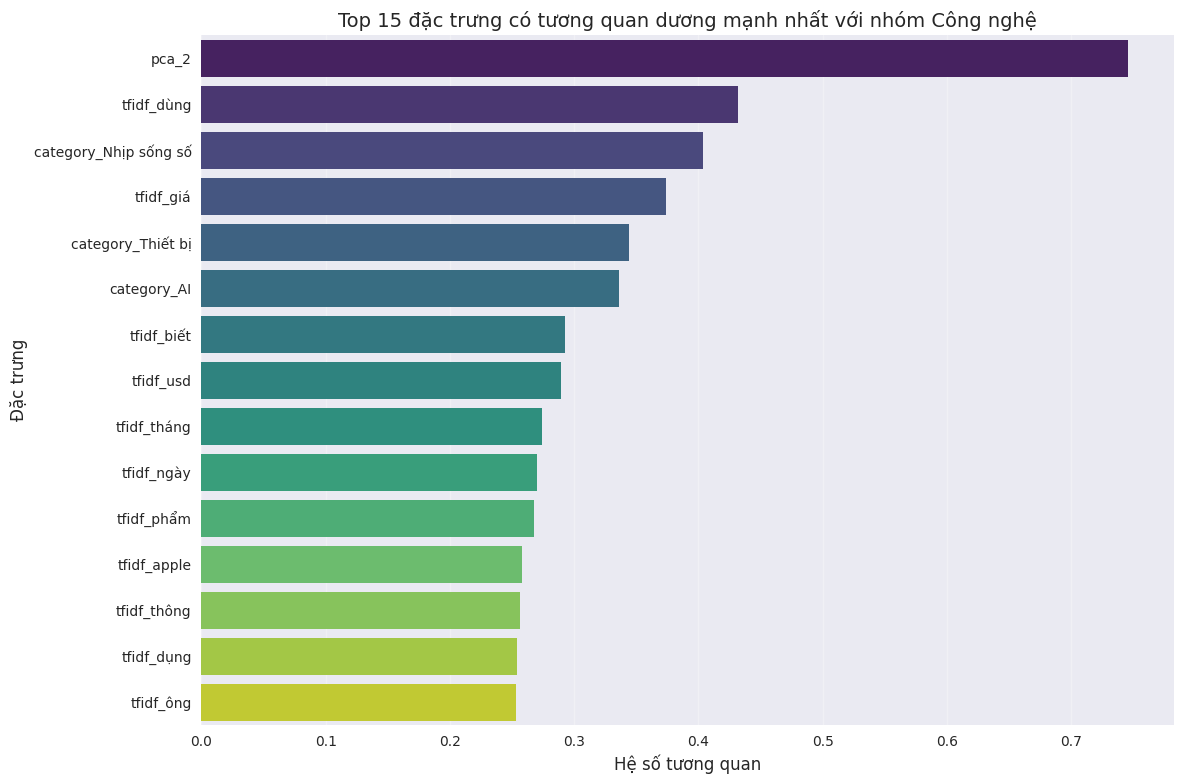

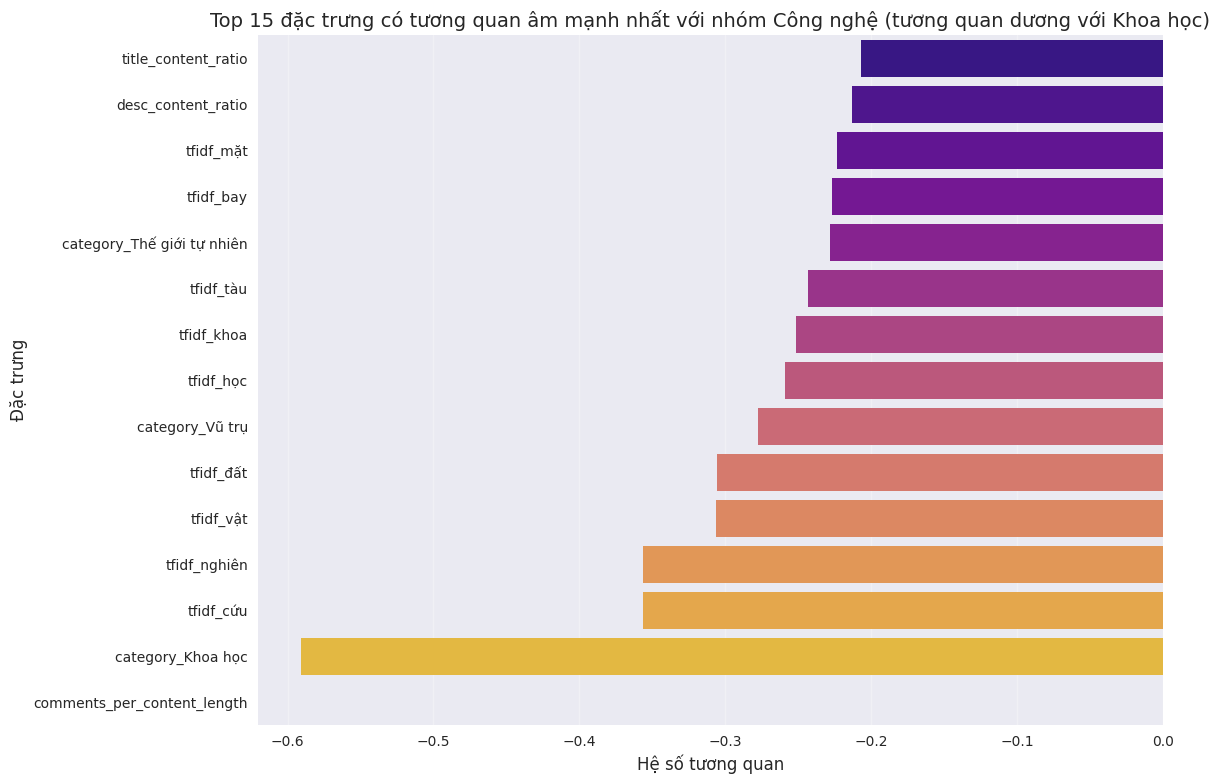

In [9]:
# Tính toán tương quan với biến mục tiêu (0 cho Khoa học, 1 cho Công nghệ)
df_features['target'] = (df_features['group'] == 'Công nghệ').astype(int)

# Lấy các đặc trưng số
numeric_features = df_features.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [col for col in numeric_features if col != 'target']

# Tính tương quan với biến mục tiêu
correlations = df_features[numeric_features].corrwith(df_features['target']).sort_values(ascending=False)

# Hiển thị top 15 đặc trưng có tương quan dương mạnh nhất
plt.figure(figsize=(12, 8))
sns.barplot(y=correlations.head(15).index, x=correlations.head(15).values, palette='viridis')
plt.title('Top 15 đặc trưng có tương quan dương mạnh nhất với nhóm Công nghệ', fontsize=14)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Hiển thị top 15 đặc trưng có tương quan âm mạnh nhất
plt.figure(figsize=(12, 8))
sns.barplot(y=correlations.tail(15).index, x=correlations.tail(15).values, palette='plasma')
plt.title('Top 15 đặc trưng có tương quan âm mạnh nhất với nhóm Công nghệ (tương quan dương với Khoa học)', fontsize=14)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Nhận xét**: 
- Nhiều đặc trưng có tương quan mạnh với biến mục tiêu, với hệ số tương quan trên 0.3 (giá trị tuyệt đối), cho thấy chúng có khả năng dự đoán tốt.
- Các đặc trưng TF-IDF chiếm đa số trong top đặc trưng quan trọng, chứng tỏ nội dung văn bản là yếu tố phân biệt chủ đạo giữa hai nhóm.
- Một số đặc trưng kỹ thuật như text_complexity (độ phức tạp văn bản), title_content_ratio (tỷ lệ tiêu đề/nội dung) cũng có tương quan đáng kể.

## 6.3. Kết luận về tính khả thi của bài toán

Dựa trên tất cả các phân tích trên, chúng ta có thể đưa ra kết luận về tính khả thi của bài toán phân loại bài viết VNExpress thành hai nhóm Công nghệ và Khoa học:

### Đánh giá tính khả thi:

1. **Cân bằng dữ liệu**: Dữ liệu có sự cân bằng tốt giữa hai nhóm (khoảng 51% Công nghệ và 49% Khoa học), tạo điều kiện thuận lợi cho việc huấn luyện mô hình mà không bị thiên lệch.

2. **Khả năng phân biệt**: Kết quả t-SNE và silhouette score cho thấy có sự phân tách khá rõ ràng giữa hai nhóm, với điểm silhouette ở mức trung bình đến khá.

3. **Từ khóa đặc trưng**: Phân tích từ khóa TF-IDF cho thấy mỗi nhóm có các từ khóa đặc trưng riêng biệt, giúp cho việc phân loại dễ dàng hơn.

4. **Tương quan đặc trưng**: Nhiều đặc trưng có tương quan mạnh với biến mục tiêu, chứng tỏ chúng có khả năng dự đoán tốt.

5. **Chất lượng dữ liệu**: Sau quá trình làm sạch và chuẩn hóa, dữ liệu có chất lượng tốt với ít giá trị thiếu và nhiễu.

**Kết luận**: Bài toán phân loại bài viết VNExpress thành hai nhóm Công nghệ và Khoa học **có tính khả thi cao**. Dữ liệu có chất lượng tốt, cân bằng, và các đặc trưng có khả năng phân biệt tốt giữa hai nhóm.

## 6.4. Xác định tập đặc trưng hữu ích cho mô hình phân loại

Để xây dựng mô hình phân loại hiệu quả, chúng ta cần chọn lọc một tập đặc trưng hữu ích. Dựa trên các phân tích từ các notebook trước, chúng ta sẽ đề xuất các nhóm đặc trưng sau:

### 6.4.1. Đặc trưng từ nội dung văn bản (Text Features)

1. **TF-IDF Vector**: Các đặc trưng TF-IDF được chọn lọc (top 100) từ tiêu đề, mô tả, và nội dung bài viết
   - Các đặc trưng TF-IDF quan trọng như 'tfidf_ai', 'tfidf_nghiên_cứu', 'tfidf_công_nghệ', 'tfidf_trái_đất'...

2. **Thống kê văn bản**:
   - `text_complexity`: Độ phức tạp của văn bản (tỷ lệ độ dài/số từ)
   - `title_content_ratio`: Tỷ lệ độ dài tiêu đề/nội dung
   - `desc_content_ratio`: Tỷ lệ độ dài mô tả/nội dung

### 6.4.2. Đặc trưng thời gian và metadata

1. **Đặc trưng thời gian**:
   - `time_of_day`: Thời điểm đăng bài trong ngày (sáng, trưa, chiều, tối, đêm khuya)
   - `is_weekend`: Đánh dấu bài viết đăng vào cuối tuần

2. **Metadata**:
   - `comments_per_content_length`: Số bình luận trên độ dài nội dung
   - Các đặc trưng tag quan trọng đã được mã hóa
   - Các đặc trưng category đã được mã hóa

### 6.4.3. Đặc trưng giảm chiều

1. **Thành phần PCA**: 10 thành phần PCA đầu tiên, giữ lại khoảng 95% phương sai của dữ liệu

### 6.4.4. Tổng hợp: Bộ đặc trưng đề xuất cho mô hình phân loại

In [10]:
# Đề xuất các nhóm đặc trưng hữu ích dựa trên tương quan với biến mục tiêu
# 1. Top TF-IDF features
tfidf_features = [col for col in correlations.index if col.startswith('tfidf_')]
top_tfidf = tfidf_features[:50]  # Top 50 đặc trưng TF-IDF

# 2. Đặc trưng kỹ thuật đã tạo
engineered_features = ['title_content_ratio', 'desc_content_ratio', 
                      'comments_per_content_length', 'is_weekend', 'text_complexity']

# 3. Thành phần PCA
pca_features = [col for col in correlations.index if col.startswith('pca_')][:10]

# Tổng hợp các đặc trưng đề xuất
recommended_features = top_tfidf + engineered_features + pca_features

print(f"Số lượng đặc trưng đề xuất: {len(recommended_features)}")
print(f"\nBreakdown theo nhóm:")
print(f"- TF-IDF features: {len(top_tfidf)}")
print(f"- Engineered features: {len(engineered_features)}")
print(f"- PCA components: {len(pca_features)}")
print(f"\nDanh sách đặc trưng kỹ thuật đề xuất: {engineered_features}")
print(f"\nTop 10 đặc trưng TF-IDF đề xuất: {top_tfidf[:10]}")

Số lượng đặc trưng đề xuất: 51

Breakdown theo nhóm:
- TF-IDF features: 36
- Engineered features: 5
- PCA components: 10

Danh sách đặc trưng kỹ thuật đề xuất: ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 'is_weekend', 'text_complexity']

Top 10 đặc trưng TF-IDF đề xuất: ['tfidf_dùng', 'tfidf_giá', 'tfidf_biết', 'tfidf_usd', 'tfidf_tháng', 'tfidf_ngày', 'tfidf_phẩm', 'tfidf_apple', 'tfidf_thông', 'tfidf_dụng']


## 6.5. Tổng kết và hướng phát triển tiếp theo

### Tổng kết:

Qua quá trình phân tích dữ liệu từ 5 notebook trước, chúng ta đã đạt được các kết quả sau:

1. Đánh giá được tính khả thi **cao** của bài toán phân loại bài viết VNExpress thành nhóm Công nghệ và Khoa học, dựa trên:
   - Dữ liệu cân bằng giữa hai nhóm
   - Khả năng phân biệt tốt của các đặc trưng
   - Từ khóa đặc trưng rõ ràng cho từng nhóm
   - Nhiều đặc trưng có tương quan mạnh với biến mục tiêu

2. Xác định được bộ đặc trưng hữu ích cho việc xây dựng mô hình phân loại, bao gồm:
   - Các đặc trưng TF-IDF quan trọng từ nội dung văn bản
   - Các đặc trưng kỹ thuật như độ phức tạp văn bản, tỷ lệ tiêu đề/nội dung
   - Các đặc trưng thời gian và metadata
   - Các thành phần PCA giúp giảm chiều dữ liệu

### Hướng phát triển tiếp theo:

1. **Xây dựng mô hình phân loại**:
   - Thử nghiệm các thuật toán phân loại như SVM, Random Forest, Logistic Regression
   - Áp dụng các mô hình deep learning như CNN, RNN cho dữ liệu văn bản
   - So sánh hiệu suất các mô hình để chọn ra mô hình tốt nhất

2. **Tối ưu hóa mô hình**:
   - Tinh chỉnh siêu tham số (hyperparameter tuning)
   - Thử nghiệm các kỹ thuật ensemble để kết hợp nhiều mô hình
   - Áp dụng k-fold cross-validation để đánh giá mô hình chính xác hơn

3. **Triển khai và đánh giá**:
   - Xây dựng hệ thống phân loại tự động cho bài viết mới
   - Đánh giá hiệu suất mô hình trên dữ liệu mới
   - Cập nhật và cải tiến mô hình theo thời gian

Với bộ đặc trưng đề xuất và các hướng phát triển trên, chúng ta hoàn toàn có thể xây dựng được hệ thống phân loại bài viết VNExpress thành công với độ chính xác cao.

# Tài liệu tham khảo:
- [VNExpress](https://vnexpress.net/)
